# Demonstration: Gaussian processes 

In [1]:
%matplotlib inline
import numpy as np
import scipy.stats as stats
from scipy.stats import multivariate_normal as MVN
import matplotlib.pyplot as plt
import corner

## Gaussian processes as high-dimensional Gaussian distributions

A Gaussian process (GP) is a collection of random variables, $( Y_x )_{x\geq 0}$ (labeled by a continuous index $x$) such that any finite number of such variables has a joint, multivariate Gaussian distribution. In fact, this implies that the GP is a continuous-time stochastic process although we use $x$ instead of $t$ as our index variable. 

We will typically consider any number $n=1, 2, \ldots$ of indices with $0 \leq x_1 < x_2, < \ldots < x_n$.

For any $n$, the GP is completely determined by its mean vector $\boldsymbol{\mu}$, with $\mu_i = \mathbb{E}(Y_i)$, and covariance matrix $\boldsymbol{\Sigma}$, with $\Sigma_{ij} = \text{Cov}(Y_i,Y_j)$, for $i,j \in 1, \ldots, n$ and $Y_k \equiv Y(x_k)$.

Although a GP can formally involve any valid covariance matrix, we will restrict ourselves to positive covariances $\Sigma_{ij}>0$. Furthermore, we will usually have correlations that become weaker with increasing distance in the index variable, i.e.,

$$
\rho_{ij} < \rho_{ik}, \text{ for } x_i < x_j < x_k.
$$

(recall that $\rho_{ij} = \frac{\Sigma_{ij}}{\sigma_i \sigma_j}$, where $\sigma_i^2 = \Sigma_{ii})$.

### Multivariate normal distributions

Consider the set of random variables 

$$
Y_1, Y_2, \ldots, Y_k.
$$

These have a multivariate normal (Gaussian) distribution if the linear combination

$$
Z = a_1 Y_1 + a_2 Y_2 + \ldots + a_k Y_k
$$

has a univariate normal distribution for all real numbers $(a_1, a_2, \ldots, a_k)$. The multivariate normal distribution is completely specified by the mean vector $\boldsymbol{\mu}$ and the covariance matrix $\boldsymbol{\Sigma}$. In fact, the random variable $Z \sim \mathcal{N}(\mu_Z,\sigma_Z^2)$ with 

\begin{align*}
\mu_Z &= \sum_{i=1}^k a_i \mu_i \\
\sigma_Z^2 &= \sum_{i,j=1}^k a_i a_j \Sigma_{i.j}
\end{align*}

In [2]:
def randomCovarianceMatrix(D, noise=0.001):
    """
    Generate a random covariance matrix.

    Makes sure that it is symmetric and positive, semidefinite. 
    Increasing variances along diagonal.
    All correlations are positive

    Args:
        D: int, number of dimensions
        noise: float, white noise along diagonal

    Returns:
        ndarray of shape (D,D)
    """
    # Shape (D,1) array of sorted, uniformly [0,1] distributed random numbers
    tmp = np.sort(np.random.rand(D))[:,None]
    # Symmetric, shape (D,5) array
    tmp2 = tmp**np.arange(5)
    # Shape (D,D) array
    covarianceMatrix = 2.*np.dot(tmp2,tmp2.T) + noise*np.eye(D)
    assert np.all(np.linalg.eigvals(covarianceMatrix) > 0), "The matrix is not positive semidefinite"
    return covarianceMatrix

In [3]:
# Generate a D-dimensional random mean vector and covariance matrix
D = 4
muMV = np.random.rand(D)
SigmaMV = randomCovarianceMatrix(D)
# and collect N samples
N = 10000
Y = MVN(mean=muMV, cov=SigmaMV).rvs(size=N)

In [4]:
stdMV = np.sqrt(np.diag(SigmaMV))

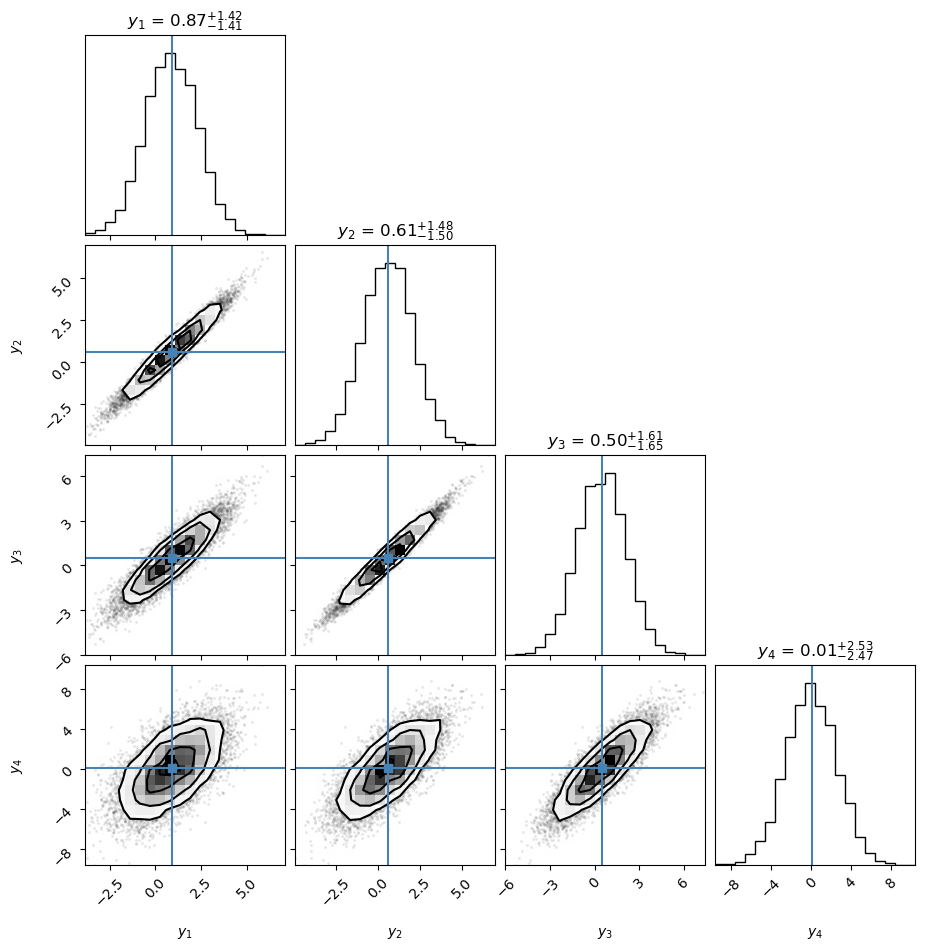

In [5]:
# Corner plot with samples from bi- and univariate marginals.
# Note that corner shows a histogram and iso-probability contours in the densest region (and samples outside)
corner.corner(Y,labels=[rf'$y_{i+1}$' for i in range(D)],truths=muMV,show_titles=True,plot_contours=True,);

In [6]:
# A linear combination Z = \sum_i a_i Y_i should have a univariate random distribution
# Create random amplitudes in [-5,5]
a = -5. + 10.*np.random.rand(D,1)
# and the linear combination
Z = np.dot(Y,a)
# with mean and variance
muZ = np.dot(muMV,a)
varZ = np.dot(np.dot(a.T,SigmaMV),a)

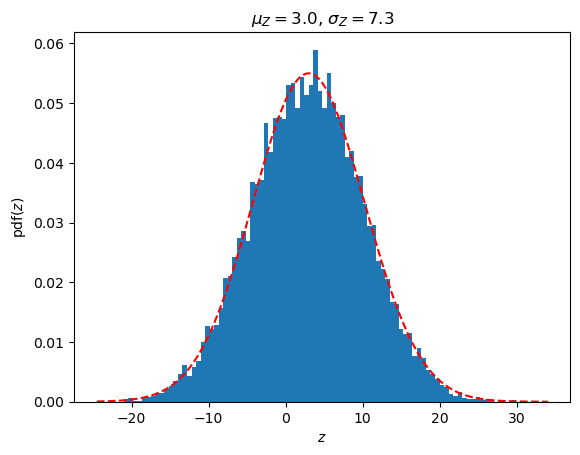

In [7]:
# Plot the histogram of samples together with the analytical distribution
fig,ax = plt.subplots(1,1)
ax.hist(Z,bins=100,density=True)
Zrange = np.linspace(min(Z), max(Z), 1000)
Zdist = stats.norm(loc=muZ,scale=np.sqrt(varZ))
ax.plot(Zrange,Zdist.pdf(Zrange),'r--')
ax.set_title(rf'$\mu_Z = {muZ.flatten()[0]:.1f}$, $\sigma_Z = {np.sqrt(varZ.flatten()[0]):.1f}$')
ax.set_xlabel(r'$z$')
ax.set_ylabel(r'pdf($z$)');

## Sampling and plotting multivariate Gaussians

Let's first define some plotting functions that we'll use later. 
Adapted partly from a tutorial by [Andreas Damianou](http://adamian.github.io/talks/Brown2016.html) (2016).

In [8]:
def plot_Gaussian_contours(x,y,mu,cov,N=100):
    """
    Plot contours of a 2D multivariate Gaussian based on N points. Given points x and y are 
    given for the limits of the contours
    """
    X, Y = np.meshgrid(np.linspace(x.min()-0.3,x.max()+0.3,100), np.linspace(y.min()-0.3,y.max()+0.3,N))
    dist = MVN(mu, cov)
    Z = dist.pdf(np.dstack((X,Y)))
    plt.contour(X,Y,Z,levels=3)
    plt.xlabel(r'$y_1$')
    plt.ylabel(r'$y_2$')

def plot_sample_dimensions(samples, colors=None, markers=None, ms=10):
    """
    Given a set of samples from a bivariate Gaussian, plot them, but instead of plotting them
    y1 vs y2, plot them as [y1 y2] vs ['1', '2']
    """
    N = samples.shape[0]
    D = samples.shape[1]
    
    t=np.array(range(1,D+1))

    for i in np.arange(N):
        if colors is None and markers is None:
            plt.plot(t,samples[i,:], '-o',ms=ms)
        elif colors is None:
            plt.plot(t,samples[i,:], '-',marker=markers[i],ms=ms)
        elif markers is None:
            plt.plot(t,samples[i,:], '-o',color=colors[i],ms=ms)
        else:
            plt.plot(t,samples[i,:], '-',color=colors[i],marker=markers[i],ms=ms)
    plt.xlim([0.8,t[-1]+0.2])
    plt.ylim([samples.min()-0.3, samples.max()+0.3])
    plt.xlabel('d = {' + str(t) + '}')
    plt.ylabel(r'$y_d$')
    plt.gca().set_title(str(N) + ' samples from a bivariate Gaussian')


def set_limits(samples):
    plt.xlim([samples[:,0].min()-0.3, samples[:,0].max()+0.3])
    plt.ylim([samples[:,1].min()-0.3, samples[:,1].max()+0.3])

Test two different ways of plotting a bivariate Gaussian.

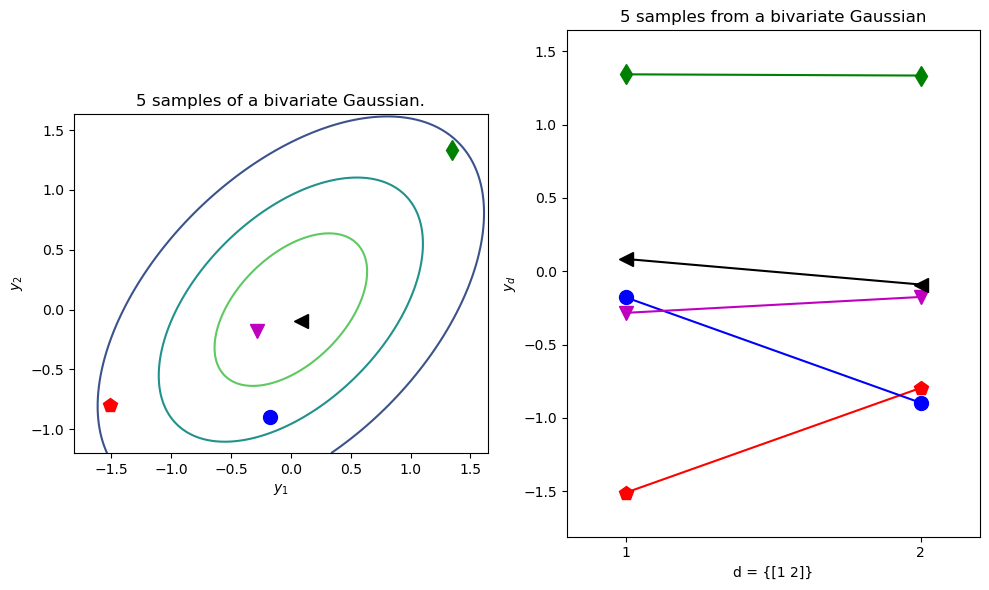

In [9]:
colors = ['r','g','b','m','k']
markers = ['p','d','o','v','<']

N=5 # Number of samples
mu = np.array([0,0])  # Mean of the 2D Gaussian
sigma = np.array([[1, 0.5], [0.5, 1]]); # covariance of the Gaussian

# Generate samples
np.random.seed(10)
samples = MVN(mean=mu,cov=sigma).rvs(size=N) 

f=plt.figure(figsize=(10,6)); 
ax1=plt.subplot(1, 2, 1,autoscale_on=True, aspect='equal')
#set_limits(samples)
plot_Gaussian_contours(samples[:,0],samples[:,1],mu,sigma)

# Plot samples
for i in np.arange(N):
    ax1.plot(samples[i,0],samples[i,1], color=colors[i], marker=markers[i],ms=10)
ax1.set_title(f'{N} samples of a bivariate Gaussian.')

ax2=plt.subplot(1, 2, 2,autoscale_on=True)#, aspect='equal')
ax2.set_xticks([1,2])
plot_sample_dimensions(samples=samples, colors=colors, markers=markers)

f.tight_layout()

Repeat as before, but now we'll plot many samples from two kinds of Gaussians: one which with strongly correlated dimensions and one with weak correlations

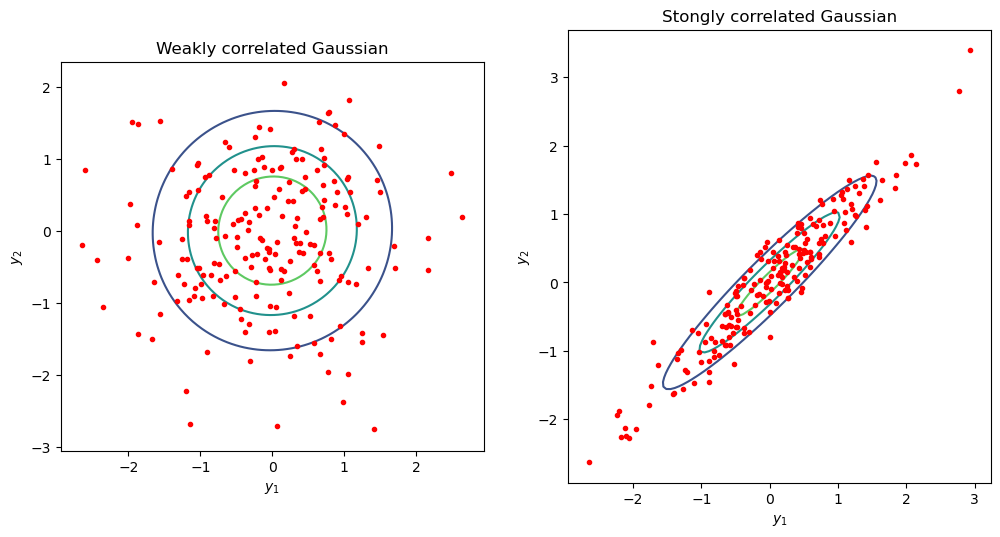

In [10]:
# Plot with contours. Compare a correlated vs almost uncorrelated Gaussian

sigmaUncor = np.array([[1, 0.02], [0.02, 1]]);
sigmaCor = np.array([[1, 0.95], [0.95, 1]]);

f=plt.figure(figsize=(12,12)); 

ax=plt.subplot(1, 2, 1); ax.set_aspect('equal')
samplesUncor=MVN(mean=mu,cov=sigmaUncor).rvs(size=200)
plot_Gaussian_contours(samplesUncor[:,0],samplesUncor[:,1], mu, sigmaUncor)
ax.plot(samplesUncor[:,0],samplesUncor[:,1], 'r.')
ax.set_title('Weakly correlated Gaussian')

ax=plt.subplot(1, 2, 2); ax.set_aspect('equal')
samplesCor=MVN(mean=mu,cov=sigmaCor).rvs(size=200)
plot_Gaussian_contours(samplesCor[:,0],samplesCor[:,1], mu, sigmaCor)
ax.plot(samplesCor[:,0],samplesCor[:,1], 'r.')
ax.set_title('Stongly correlated Gaussian');

But let's plot them as before dimension-wise...

> Which one is which?

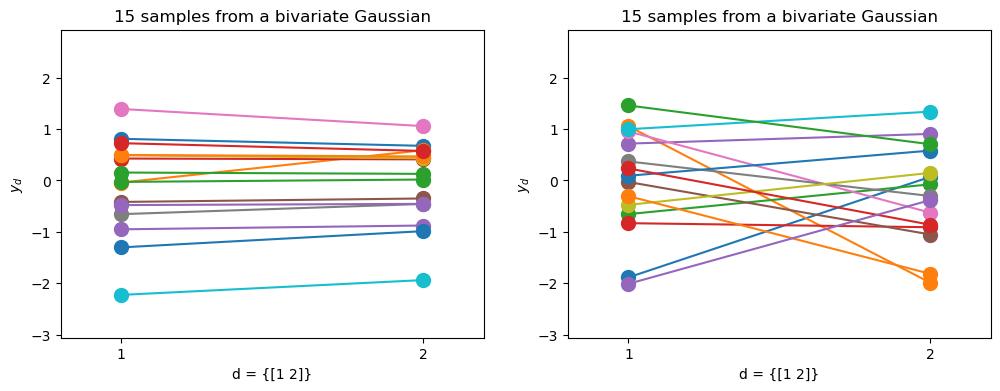

In [11]:
f=plt.figure(figsize=(12,4)); 
perm = np.random.permutation(samplesUncor.shape[0])[0::14]

ax1=plt.subplot(1, 2, 2); ax1.set_aspect('auto')
plot_sample_dimensions(samplesUncor[perm,:])
ax2=plt.subplot(1, 2, 1,sharey=ax1); ax2.set_aspect('auto')
plot_sample_dimensions(samplesCor[perm,:])
if False:
    ax1.set_title('Weakly correlated');
    ax2.set_title('Strongly correlated')
for ax in [ax1,ax2]:
    ax.set_xticks([1,2])
plt.ylim([samplesUncor.min()-0.3, samplesUncor.max()+0.3]);

* The strongly correlated Gaussian gives more "horizontal" lines in the dimension-wise plot.

* More importantly, by using the dimension-wise plot, we are able to plot Gaussians which have more than two dimensions. Below we plot N samples from a D=8-dimensional Gaussian. 

* Because I don't want to write down the full 8x8 covariance matrix, I define a "random" one through a mathematical procedure that is guaranteed to give me back a positive definite and symmetric matrix (i.e. a valid covariance). More on this later.

Covariance matrix:
[[2.02 2.09 2.12 2.15 2.16 2.17 2.19 2.21]
 [2.09 2.45 2.69 2.89 2.98 3.07 3.27 3.42]
 [2.12 2.69 3.1  3.48 3.66 3.83 4.23 4.55]
 [2.15 2.89 3.48 4.05 4.33 4.59 5.22 5.73]
 [2.16 2.98 3.66 4.33 4.65 4.96 5.72 6.33]
 [2.17 3.07 3.83 4.59 4.96 5.32 6.19 6.9 ]
 [2.19 3.27 4.23 5.22 5.72 6.19 7.38 8.35]
 [2.21 3.42 4.55 5.73 6.33 6.9  8.35 9.54]]
Eigenvalues all larger than zero
[35.57  2.75  0.19  0.    0.    0.    0.    0.  ]


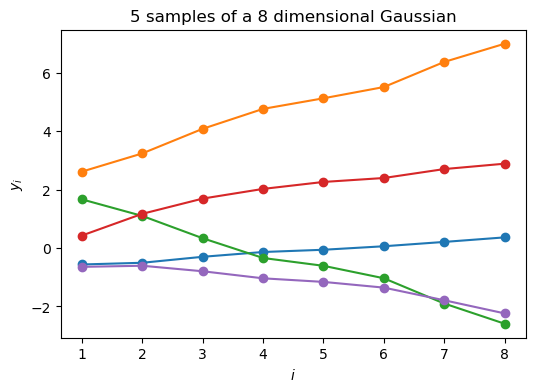

In [12]:
N=5
D = 8
mu = np.zeros(D)

# Generate a random covariance matrix
sigma = randomCovarianceMatrix(D) 

with np.printoptions(precision=2, suppress=True):
    print('Covariance matrix:')
    print(sigma)
    print('Eigenvalues all larger than zero')
    print(np.linalg.eigvals(sigma))

samples = MVN(mean=mu,cov=sigma).rvs(size=N)

fig,ax = plt.subplots(1,1,figsize=(6,4))
for i in np.arange(N):
    ax.plot(np.arange(D)+1,samples[i,:], '-o')

ax.set_ylabel(r'$y_i$')
ax.set_xlabel(r'$i$')
ax.set_title(f'{N} samples of a {D} dimensional Gaussian');

Taking this even further, we can plot samples from a 200-dimensional Gaussian in the dimension-wise plot. 

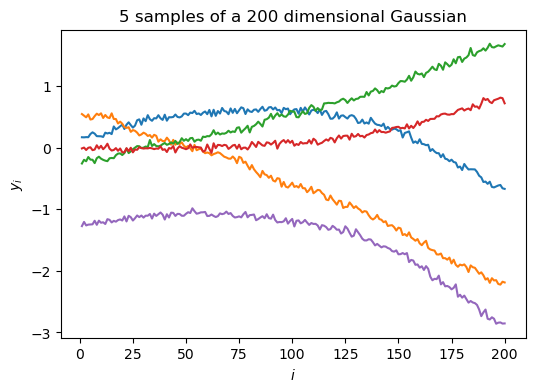

In [13]:
N=5
D = 200
mu = np.zeros(D)

# Generate a random covariance matrix
sigma = randomCovarianceMatrix(D) 

samples = MVN(mean=mu,cov=sigma).rvs(size=N)

fig,ax = plt.subplots(1,1,figsize=(6,4))
for i in np.arange(N):
    ax.plot(np.arange(D)+1,samples[i,:], '-')

ax.set_ylabel(r'$y_i$')
ax.set_xlabel(r'$i$')
ax.set_title(f'{N} samples of a {D} dimensional Gaussian');

We see that each sample now starts looking like a "smooth" curve (notice that the random variables are highly correlated). This illustrates why a GP can be seen as an *infinite dimensional multivariate Gaussian* that can be used as a *prior over functions*.

## Mean and covariance function

Similarly to how a D-dimensional Gaussian is parameterized by its mean vector and its covariance matrix, a GP is parameterized by a mean *function* and a covariance *function*. These can be written as functions of the index variable $x$. We'll assume (without loss of generality) that the mean function is $\mu(x) = \mathbf{0}$. As for the covariance function, $C(x,x')$, it is a function that receives as input two locations $x,x'$ belonging to the input domain, i.e. $x,x' \in \mathcal{X}$, and returns the value of their co-variance.

In this way, if we have a *finite* set of input locations we can evaluate the covariance function at every pair of locations and obtain a covariance matrix $\mathbf{C}$. We write:

$$
\mathbf{C} = C(\mathbf{x}, \mathbf{x}').
$$

### Covariance functions, aka kernels

We saw above their role for creating covariance matrices from training inputs, thereby allowing us to work with a finite domain when it is potentially infinite.

We'll see below that the covariance function is what encodes our assumption about the GP. By selecting a covariance function, we are making implicit assumptions about the shape of the function we wish to encode with the GP, for example how smooth it is.

Even if the covariance function has a parametric form, combined with the GP it gives us a nonparametric model. In other words, the covariance function is specifying the general properties of the GP function we wish to encode, and not a specific parametric form for it.

Below we define two very common covariance functions: The RBF (also known as Exponentiated Quadratic or Gaussian kernel) which is differentiable infinitely many times (hence, very smooth),

$$
C_\mathrm{RBF}(\mathbf{x}_{i},\mathbf{x}_{j}) = \sigma_f^2 \exp \left( -\frac{1}{2\ell^2} \sum_{q=1}^Q (x_{i,q} - x_{j,q})^2\right)
$$

where $Q$ denotes the dimensionality of the input space. Its parameters are: the *lengthscale*, $\ell$ and the signal variance $\sigma_f^2$. We also note that this kernel is *stationary*, meaning that it only depends on the distance $\left| \mathbf{x}_{i} - \mathbf{x}_{j} \right|$. 

There are many other kinds of kernels. An example of a non-stationary one is the linear kernel:

$$
C_\mathrm{lin}(\mathbf{x}_{i},\mathbf{x}_{j}) = \sigma^2 \mathbf{x}_{i}^T \mathbf{x}_{j}
$$

Below, we will implement and investigate them.

#### The RBF kernel (a.k.a Gaussian)

In [14]:
def RBFkernel(dX, alpha=np.array([1,1])):
    """
    The stationary RBF kernel function for a one-dimension space. 
    
    The distance matrix can be an arbitrarily shaped numpy array so make sure to
    use functions like `numpy.exp` for exponentiation.
    
    Args:
        dX: distance matrix. Array (N_row,N_col)
        alpha: List-like. Hyperparameters corresponding to [RBF signal variance, RBF correlation length].
        
    Returns:
        Kernel elements. Array with same shape as dX.
    """
    RBF_variance = alpha[0]
    RBF_lengthscale = alpha[1]
    return RBF_variance * np.exp(-0.5*(dX/RBF_lengthscale)**2)

def cov_RBF(X_row, X_col, alpha=np.array([1,1])):
    """
    Construct the covariance matrix for input positions X_row x X_col
        
    Args:
        X_row: list-like, length N_row
        X_col: list_like, length N_col
        alpha: hyperparameters [RBF signal variance, RBF correlation length]
        
    Returns:
        Covariance matrix. Shape (N_row, N_col)
    """
    N_row = len(X_row)
    X_row = np.array(X_row).reshape(N_row,1)
    N_col = len(X_col)
    X_col = np.array(X_col).reshape(N_col,1)

    X_row_tile = np.tile(X_row,N_col)
    # dX array is of shape (N_row, N_col)
    dX = X_col.T - X_row_tile
            
    return RBFkernel(dX, alpha=alpha)

Given hyperparameters $\boldsymbol{\alpha}$, we plot the resulting covariance matrix and samples from a GP with this covariance function.

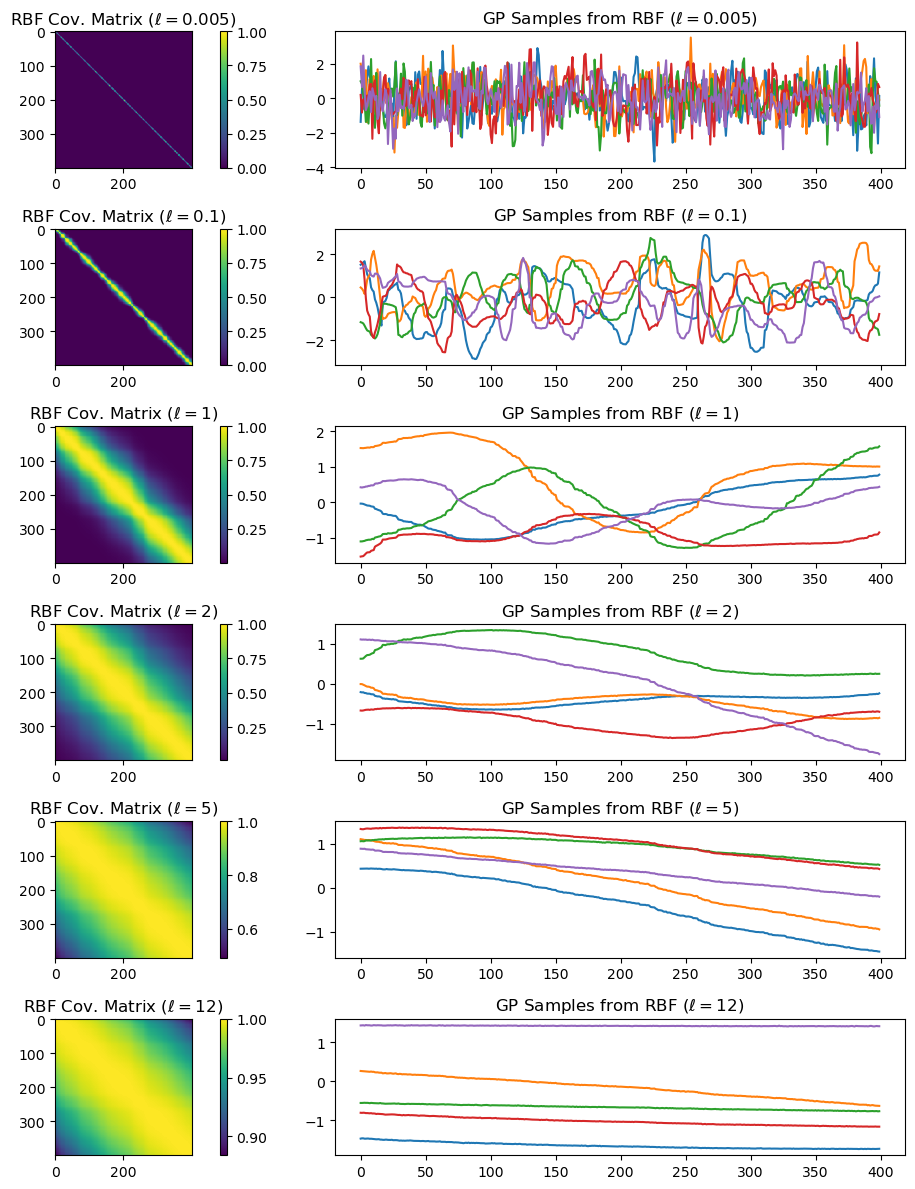

In [15]:
X = np.sort(np.random.rand(400, 1) * 6 , axis=0)

params_rbf    = [0.005, 0.1, 1, 2, 5, 12]
K = len(params_rbf)

num_samples=5
plt.figure(figsize=(12,12))
j=1
for i in range(K):
    plt.subplot(K,2,j)
    K_rbf = cov_RBF(X,X,alpha=np.array([1,params_rbf[i]]))
    plt.imshow(K_rbf)
    plt.colorbar()
    plt.gca().set_title(rf'RBF Cov. Matrix ($\ell={params_rbf[i]}$)')
    
    plt.subplot(K,2,j+1)
    # Assume a GP with zero mean
    mu=np.zeros((1,K_rbf.shape[0]))[0,:]
    for s in range(num_samples):
        # nugget is a small white noise addition to the diagonal elements to ensure positive definiteness
        nugget = 1e-5*np.eye(K_rbf.shape[0])
        sample = np.random.multivariate_normal(mean=mu, cov=K_rbf+nugget)
        plt.plot(sample)
    plt.gca().set_title(rf'GP Samples from RBF ($\ell={params_rbf[i]}$)')
    j+=2
    
plt.tight_layout()

## Example: GP models for regression
### No-core shell model $\hbar\omega$ dependence

In [32]:
# import some NCSM data from
# Phys. Rev. C 97, 034328 (2018)
(E,Nmax,hw)=np.loadtxt('data/Li6E_NNLOopt_Nmax10.txt',unpack=True)

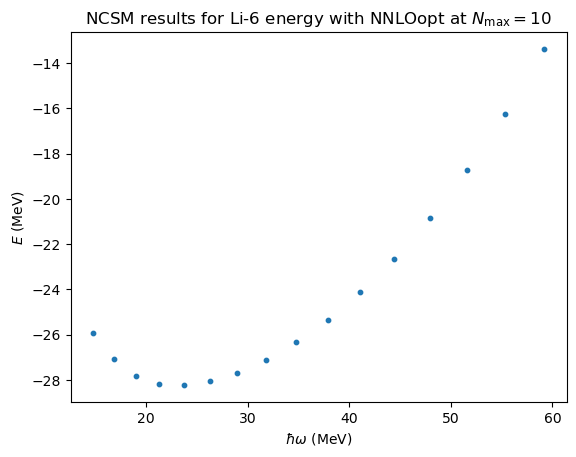

In [33]:
fig,ax = plt.subplots(nrows=1,ncols=1)
ax.set_ylabel(r'$E$ (MeV)');
ax.set_xlabel(r'$\hbar\omega$ (MeV)');
ax.set_title(r'NCSM results for Li-6 energy with NNLOopt at $N_\mathrm{max}=10$')
ax.scatter(hw,E,s=10);

In [75]:
# We will test our GP by training on every third data point and validate on the rest.
xt = x[::3, np.newaxis]
yt = y[::3, np.newaxis]

In [76]:
# Using GP regression functionality from sklearn
import sklearn.gaussian_process as gp_sklearn
# construct an RBF kernel with an initial guess for the hyperparameters
kernel_RBF = gp_sklearn.kernels.ConstantKernel(5.0) * gp_sklearn.kernels.RBF(length_scale=10.0)
# set up the GP regressor
# - use the kernel function that we just defined
# - training data normalized to mean=0, std=1 with `normalize_y=True` 
# - use a single start point (the initial guess) when optimizing the hyperparameters (see below)
# - add a fixed white noise
nugget = 1e-6
gpr_sklearn = gp_sklearn.GaussianProcessRegressor(kernel=kernel_RBF, \
                            normalize_y=True, n_restarts_optimizer=0, alpha=nugget)

In [77]:
# print the initial guess and bounds for GP regressor hyperparameters
params = kernel_RBF.get_params()
for key in sorted(params): print(f"{key} : {params[key]}")

k1 : 2.24**2
k1__constant_value : 5.0
k1__constant_value_bounds : (1e-05, 100000.0)
k2 : RBF(length_scale=10)
k2__length_scale : 10.0
k2__length_scale_bounds : (1e-05, 100000.0)


In [78]:
# Fit kernel hyperparameters
gpr_sklearn.fit(xt, yt)

# Extract and print the optimum values
sigma_f_opt = np.sqrt(gpr_sklearn.kernel_.k1.get_params()['constant_value'])
l_opt = gpr_sklearn.kernel_.k2.get_params()['length_scale']    
print(f'       l = {l_opt:.3f}')
print(f' sigma_f = {sigma_f_opt:.3f}')
print(f'sigma_nu = {nugget}')

       l = 15.329
 sigma_f = 1.384
sigma_nu = 1e-06


In [79]:
# Utility function for plotting a GP prediction with credible interval
import scipy.stats as stats

def GPplot(X_new, mu_new, cov_new, ax=None, credibility=0.95):
    """
    Plot predictions of the GP regression model.

    Args:
        X_new: New input locations. List-like of length N_new.
        mu_new: GP regressor mean predictions. Array of shape (N_new,1).
        cov_new: GP regressor mean predictions. Array of shape (N_new, N_new).
        ax: Axes handle for plot. Will be created and returned if None. (default None)
        credibility: probability mass to include in the posterior prediction (float<1, default=0.95)
    
    Returns:
        Axes handle
    """
    assert credibility < 1.
    assert credibility > 0.
    # Determine the width of the band
    bandwidth_factor = stats.norm.interval(credibility)[1]
       
    X_new = np.array(X_new).reshape(-1,1)
        
    credible_range_distance = bandwidth_factor * np.sqrt(np.diag(cov_new)).flatten()

    if ax is None:
        fig, ax = plt.subplots(1,1)
    ax.fill_between(X_new.flatten(), mu_new.flatten() + credible_range_distance, \
                    mu_new.flatten() - credible_range_distance, alpha=0.1)
    ax.plot(X_new, mu_new, label='Mean')
        
    return ax

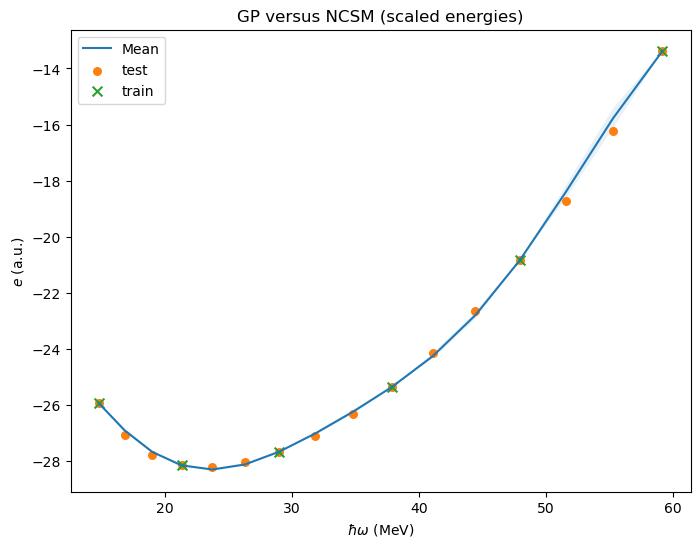

In [80]:
fig, ax = plt.subplots(1,1,figsize=(8,6))
# Compute posterior mean and covariance at points `xp`
xp = x[:, np.newaxis]
mu_opt, cov_opt = gpr_sklearn.predict(xp, return_cov=True)
GPplot(xp, mu_opt, cov_opt, ax=ax)
# Add all available data
#ax.scatter(hw,(E-mE)/sE,s=30,label='test');
ax.scatter(hw,E,s=30,label='test');
ax.scatter(xt,yt,s=50, marker='x', label='train');
ax.set(xlabel=r'$\hbar\omega$ (MeV)',ylabel=r'${e}$ (a.u.)')
ax.set_title(r'GP versus NCSM (scaled energies)')
ax.legend();

In [81]:
# We will print the largest ratios (predict-true)/predict for the validation data.
ratio_min=1.
ratio_max=1.

for i,yi in enumerate(mu_opt.flatten()):
    ratio_min=min(ratio_min,np.abs(y[i]/yi))
    ratio_max=max(ratio_max,np.abs(y[i]/yi))

print(f'Validation result: Ratio true/predict in [{ratio_min:6.4f},{ratio_max:6.4f}]')

Validation result: Ratio true/predict in [0.9930,1.0303]
